# Pacific Hake Survey ship data echopype demo
https://github.com/emiliom/

- 2021-6-24
- Document the conda environment used, how to create it
- The notebook creates two directory paths already: `./hake2017data/convertednc` and `./hake2017data/calibratednc`. netcdf files will be exported there.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import fsspec
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

from shapely.geometry import box
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import echopype as ep

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Establish AWS S3 file system connection

EK60 `.raw` data files will be read from the AWS S3 bucket maintained by NCEI WCSD. S3 directory path: `s3://ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/`

In [2]:
fs = fsspec.filesystem('s3', anon=True)

bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

## Generate list of target `.raw` files from S3 bucket based on dates

Use `fs.glob` to generate list of all raw files in the bucket, then filter on file names for target dates.

In [3]:
s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")

In [4]:
s3rawfiles[-2:]

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170913-T180733.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Winter2017-D20170615-T002629.raw']

**Select files from 2017-07-28 and 2017-07-29.**

In [5]:
s3rawfiles = [
    s3path for s3path in s3rawfiles 
    if any([f"2017{datestr}" in s3path for datestr in ['0728', '0729']])
]
len(s3rawfiles)

170

## echopype processing: convert, calibrate and export

Loop through all the selected raw files on S3 and convert, calibrate and generate MVBS. Save the converted and MVBS data to netcdf files.

### Access, convert and save to local netcdf files

In [6]:
def populate_metadata(ed, raw_fname):
    """
    Manually populate additional metadata about the dataset and the platform
    """
    
    # -- SONAR-netCDF4 Top-level Group attributes
    survey_name = "2017 Pacific Hake Survey"
    ed.top.attrs['title'] = f"{survey_name}, file {raw_fname}"
    # TODO: Expand this summary, including a link to the Hake Survey program
    ed.top.attrs['summary'] = f"EK60 raw file {raw_fname} from the {survey_name}, converted to a SONAR-netCDF4 file using echopype"

    # -- SONAR-netCDF4 Platform Group attributes
    # Per SONAR-netCDF4, for platform_type see https://vocab.ices.dk/?ref=311
    ed.platform.attrs['platform_type'] = "Research vessel"
    ed.platform.attrs['platform_name'] = "Bell M. Shimada"
    # NOAA Bell M. Shimada ship
    ed.platform.attrs['platform_code_ICES'] = "315"

Create the directories where the netcdf files will be saved, if these directories don't already exist.

In [7]:
base_dpath = Path('./exports')
base_dpath.mkdir(exist_ok=True)

converted_dpath = Path(base_dpath / 'hakesurvey_convertednc')
converted_dpath.mkdir(exist_ok=True)
calibrated_dpath = (base_dpath / 'hakesurvey_calibratednc')
calibrated_dpath.mkdir(exist_ok=True)

In [8]:
%%time

for s3rawfpath in s3rawfiles:
    raw_fpath = Path(s3rawfpath)
    try:
        ed = ep.open_raw(
            f"s3://{s3rawfpath}",
            sonar_model='EK60',
            storage_options={'anon': True}
        )
        # Manually populate additional metadata about the dataset and the platform
        populate_metadata(ed, raw_fpath.name)

        # Save to converted netcdf, then use the EchoData ed object to generate 
        # calibrated and compute-MVBS files that will also be saved to netcdf
        ed.to_netcdf(save_path=converted_dpath, overwrite=True)

        # Generate and save MVBS
        ds_Sv = ep.calibrate.compute_Sv(ed)
        ds_MVBS = ep.preprocess.compute_MVBS(
            ds_Sv,
            range_meter_bin=10,  # in meters
            ping_time_bin='20s'  # in seconds
        )
        ds_MVBS.to_netcdf(calibrated_dpath / f"MVBS_{raw_fpath.stem}.nc", overwrite=True)
    except Exception as e:
        print(f"Failed to process raw file {raw_fpath.name}")

18:38:20  parsing file Summer2017-D20170728-T000534.raw, time of first ping: 2017-Jul-28 00:05:34
18:38:24  saving /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/notebooks/exports/hakesurvey_convertednc/Summer2017-D20170728-T000534.nc
18:38:30  parsing file Summer2017-D20170728-T002507.raw, time of first ping: 2017-Jul-28 00:25:07
18:38:33  saving /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/notebooks/exports/hakesurvey_convertednc/Summer2017-D20170728-T002507.nc
18:38:39  parsing file Summer2017-D20170728-T004438.raw, time of first ping: 2017-Jul-28 00:44:38
18:38:42  saving /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/notebooks/exports/hakesurvey_convertednc/Summer2017-D20170728-T004438.nc
18:38:48  parsing file Summer2017-D20170728-T010354.raw, time of first ping: 2017-Jul-28 01:03:54
18:38:51  saving /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/notebooks/exports/hakesurvey_

### Test for time reversals

In [9]:
for datapath in converted_dpath.glob('*'):
    ed = ep.open_converted(datapath)
    # Test for a negative np.diff
    if (np.diff(ed.beam['ping_time']) < np.timedelta64(0, "ns")).any():
        print(f"Reversed time in {datapath}")

There are no time reversals!

### Examine the EchoData object for one of the data files

In [10]:
ed

EchoData: standardized raw data from exports/hakesurvey_convertednc/Summer2017-D20170728-T163359.nc
  > top: (Top-level) contains metadata about the SONAR-netCDF4 file format.
  > environment: (Environment) contains information relevant to acoustic propagation through water.
  > platform: (Platform) contains information about the platform on which the sonar is installed.
  > provenance: (Provenance) contains metadata about how the SONAR-netCDF4 version of the data were obtained.
  > sonar: (Sonar) contains specific metadata for the sonar system.
  > beam: (Beam) contains backscatter data and other beam or channel-specific data.
  > vendor: (Vendor specific) contains vendor-specific information about the sonar and the data.

## Extract GPS locations from the `Platform` group of converted raw files

Use `xarray.open_mfdataset` to open the `Platform` group from all the converted raw netcdf files as a single `xarray` dataset. We will then extract GPS timestamp (`location_time`), `latitude` and `longitude` from this group and transform that data to a [GeoPandas](https://geopandas.org/) GeoDataFrame containing point-geometry objects that are readily manipulated via geospatial operations.

Due to the presence of two time coordinates, care must be taken in defining how the combine (concatenation) operation is to be performed. See the arguments passed to `open_mfdataset`.

In [11]:
%%time

platform_ds = xr.open_mfdataset(
    str(converted_dpath / '*.nc'), group='Platform', 
    concat_dim=["location_time", "ping_time"],
    data_vars='minimal', coords='minimal'
)

CPU times: user 57.7 s, sys: 1.21 s, total: 58.9 s
Wall time: 58.8 s


In [12]:
platform_ds

<xarray.Dataset>
Dimensions:        (frequency: 3, location_time: 244846, ping_time: 88959)
Coordinates:
  * location_time  (location_time) datetime64[ns] 2017-07-28T00:05:36.1030000...
  * frequency      (frequency) float64 1.8e+04 3.8e+04 1.2e+05
  * ping_time      (ping_time) datetime64[ns] 2017-07-28T00:05:34.896999936 ....
Data variables:
    latitude       (location_time) float64 dask.array<chunksize=(244846,), meta=np.ndarray>
    longitude      (location_time) float64 dask.array<chunksize=(244846,), meta=np.ndarray>
    sentence_type  (location_time) object dask.array<chunksize=(244846,), meta=np.ndarray>
    pitch          (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
    roll           (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
    heave          (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
    water_level    (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
Attributes:
    platform_type:       Research vessel
    platform_name:       Bell M. Shimada
    platform_code_ICES:  315

We can use `location_time` (or `ping_time`) to examine the exact timestamp interval spanned by the combined dataset.

In [46]:
print(f"{platform_ds.location_time.values.min()}, {platform_ds.location_time.values.max()}")

2017-07-28T00:05:36.103000064, 2017-07-30T00:17:59.381000192


To create the GeoPandas GeoDataFrame, first transform the `latitude` and `longitude` arrays to a single Pandas DataFrame that retains the `location_time` coordinate as a common index. Then create the point GeoDataFrame from this DataFrame, and show a simple plot of the points.

In [14]:
gps_df = platform_ds.latitude.to_dataframe().join(platform_ds.longitude.to_dataframe())

gps_df.head(3)

,latitude,longitude
location_time,,
2017-07-28 00:05:36.103000064,43.533072,-124.683998
2017-07-28 00:05:37.511000064,43.533080,-124.684005
2017-07-28 00:05:37.669000192,43.533167,-124.684000


In [15]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

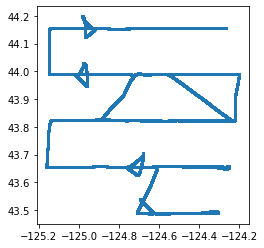

In [44]:
gps_gdf.plot(markersize=2);

## Read MVBS and plot echograms for time periods corresponding to two ship tracks

### Read combined MVBS

In [17]:
%%time
MVBS_ds = xr.open_mfdataset(
    str(calibrated_dpath / 'MVBS_*.nc'), 
    combine='by_coords'
)

CPU times: user 1.62 s, sys: 20.3 ms, total: 1.64 s
Wall time: 1.65 s


In [18]:
MVBS_ds

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8819, range: 75)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2017-07-28T00:05:20 ... 2017-07-30T...
  * frequency  (frequency) float64 1.8e+04 3.8e+04 1.2e+05
  * range      (range) float64 0.0 10.0 20.0 30.0 ... 710.0 720.0 730.0 740.0
Data variables:
    Sv         (frequency, ping_time, range) float64 dask.array<chunksize=(3, 60, 75), meta=np.ndarray>
Attributes:
    binning_mode:          physical units
    range_meter_interval:  10m
    ping_time_interval:    20s

### Extract MVBS along two N-S tracks selected via geographical bounding boxes

Define rectangular bounding boxes around two tracks oriented North-South, then plot a reference map showing all the GPS points (in red), the two bounding boxes (black), and the OOI mooring location (yellow star) examined in the accompanying Jupyter notebook.

In [19]:
tracksouth_bbox = gpd.GeoSeries(box(-125.17, 43.65, -125.14, 43.84), crs=gps_gdf.crs)
tracknorth_bbox = gpd.GeoSeries(box(-125.17, 43.98, -125.14, 44.17), crs=gps_gdf.crs)

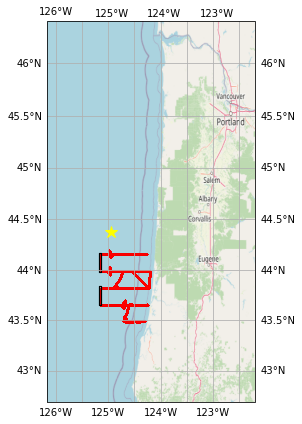

In [43]:
bnd = gps_gdf.geometry.bounds
basemap = cimgt.OSM()

_, ax = plt.subplots(
    figsize=(7, 7), subplot_kw={"projection": basemap.crs}
)
ax.set_extent([bnd.minx.min() - 1, bnd.maxx.max() + 2, bnd.miny.min() - 0.8, bnd.maxy.max() + 2.2])
ax.add_image(basemap, 7)
ax.gridlines(draw_labels=True, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)

# Plot the GPS points
gps_gdf.plot(ax=ax, transform=ccrs.PlateCarree(), markersize=0.1, color='red')

# Bounding box for selected tracks
tracksouth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', transform=ccrs.PlateCarree())
tracknorth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', transform=ccrs.PlateCarree())

# OOI CE04 offshore mooring location
plt.plot(-124.95, 44.37, marker='*', color='yellow', markersize=13, transform=ccrs.PlateCarree());

Clip the GPS locations GeoPandas GeoDataFrame `gps_gdf` generated from the `Platform` group with the two rectangular regions defined earlier for "Track 1" and "Track 2". Then extract from those clipped GeoDataFrames (`track1gps_gdf` and `track2gps_gdf`) the minimum and maximum `location_time` values for each track, and apply those values to filter `MVBS_ds` on `ping_time` slices.

In [21]:
tracksouth_gps_gdf = gpd.clip(gps_gdf, tracksouth_bbox)
tracksouth_MVBS_ds = MVBS_ds.sel(
    ping_time=slice(tracksouth_gps_gdf.index.min(), tracksouth_gps_gdf.index.max())
)

tracknorth_gps_gdf = gpd.clip(gps_gdf, tracknorth_bbox)
tracknorth_MVBS_ds = MVBS_ds.sel(
    ping_time=slice(tracknorth_gps_gdf.index.min(), tracknorth_gps_gdf.index.max())
)

### Plot MVBS echograms for the two N-S tracks, for all 3 frequencies

TODO: Described the use of `isel` selection, below.

In [54]:
def track_interval_str(trackdt):
    track_interval_title_str = (
        f"{trackdt.index.min().strftime('%b-%d %H:%MZ')}"
        f" to {trackdt.index.max().strftime('%b-%d %H:%MZ')}"
    )
    return track_interval_title_str

def plot_echograms(ds, freq_len, column_idx):
    """Plot echograms of the 3 frequencies for xarray dataset ds,
       as a column of subplots"""
    for f in range(freq_len):
        ax = axes[f][column_idx]
        # Select Sv data by frequency using the frequency coordinate index "f",
        # then plot the echogram of the selected data
        ds.Sv.isel(frequency=f).plot(
            ax=ax, 
            x='ping_time',
            y='range',
            yincrease=False,
            vmin=-80,
            vmax=-50,
        )
        if f < 2:
            ax.set_xlabel(None)
        ax.set_ylabel('range (meters)');

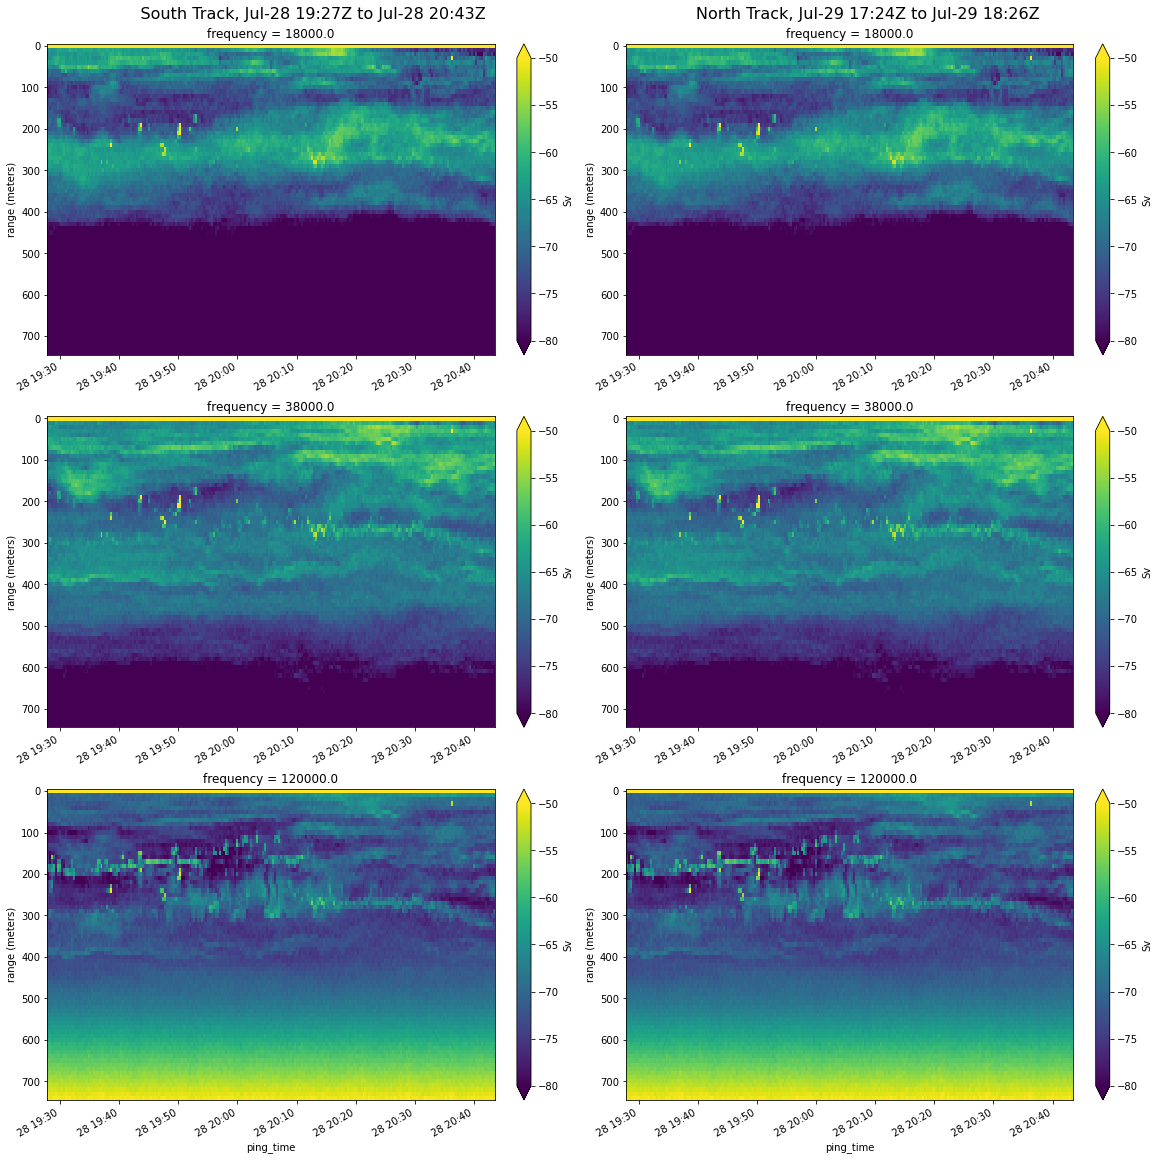

In [55]:
freq_len = len(MVBS_ds.frequency)

fig, axes = plt.subplots(nrows=freq_len, ncols=2, constrained_layout=True, figsize=(16, 16))

fig.suptitle(
    (f"    South Track, {track_interval_str(tracksouth_gps_gdf)}"
     "                                         "
     f"North Track, {track_interval_str(tracknorth_gps_gdf)}"),
    fontsize=16)

plot_echograms(tracksouth_MVBS_ds, freq_len, column_idx=0)
plot_echograms(tracksouth_MVBS_ds, freq_len, column_idx=1)

## Package versions

In [42]:
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}, fsspec: {fsspec.__version__}")

echopype: 0.5.0, xarray: 0.16.2, geopandas: 0.9.0, fsspec: 0.8.7
